### **CropY (Crop Yield Predictor)**

In [26]:
!pip install xgboost

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
data = pd.read_csv('crop_yield.csv')
data.head()

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909


### Data Cleaning

Removing 'Other' Crops

In [29]:
data = data[~data['Crop'].str.contains('other', case=False)]

Removing 'State' & 'Crop_Year'

In [30]:
data = data.drop(columns=['State', 'Crop_Year'])
data.head()

,Crop,Season,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,Whole Year,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,Kharif,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,Kharif,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,Whole Year,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),Kharif,1739.0,794,2051.4,165500.63,539.09,0.420909


Preprocessing

In [31]:
data = data.drop_duplicates()
data = data.dropna()

data = data.astype({'Area': 'float', 'Production': 'float', 'Yield': 'float', 'Annual_Rainfall': 'float', 'Fertilizer': 'float', 'Pesticide': 'float'})

data.head()
data.describe()

,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
count,1.867000e+04,1.867000e+04,18670.000000,1.867000e+04,1.867000e+04,18670.000000
mean,1.883527e+05,1.733175e+07,1432.924253,2.524995e+07,5.114940e+04,84.269532
std,7.513718e+05,2.701119e+08,818.586899,9.734769e+07,2.187337e+05,901.758217
min,5.000000e-01,0.000000e+00,301.300000,5.417000e+01,9.000000e-02,0.000000
25%,1.484000e+03,1.530000e+03,935.600000,1.985523e+05,3.802425e+02,0.609012
50%,1.010200e+04,1.599000e+04,1246.200000,1.344472e+06,2.625040e+03,1.080000
75%,8.200000e+04,1.370890e+05,1635.900000,1.078864e+07,2.145675e+04,2.530577
max,5.080810e+07,6.326000e+09,6552.700000,4.835407e+09,1.575051e+07,21105.000000


-> drop_duplicates()
Removes duplicate rows from the dataset to ensure no redundant entries.
Helps in maintaining data integrity and avoiding bias in analysis.

-> dropna()
Removes rows with missing values (NaN) to ensure complete data for analysis.
Missing data can lead to errors or biased results in statistical models.

->astype()
Converts specified columns (Area, Production, Yield, etc.) to float data type.
Ensures numerical columns are correctly formatted for calculations.

->describe()
Provides summary statistics (count, mean, std, min, max, quartiles) for numerical columns.
Helps in understanding the distribution and range of the data.

->Key Observations from describe():
Large ranges (e.g., Production max = 6.326e+09 vs. mean = 1.733e+07) suggest outliers.
High standard deviations (e.g., Yield std = 901.758) indicate wide variability.

Checking Outliers

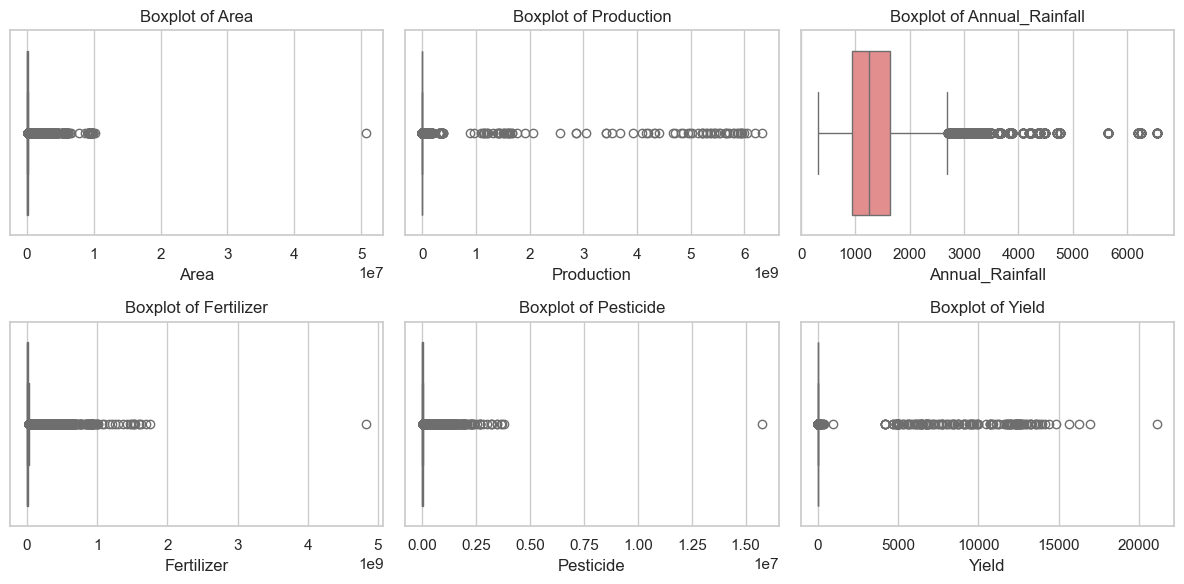

In [32]:
numerical_cols = ['Area', 'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield']

plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=data, x=col, color="lightcoral")
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Boxplots visualize the distribution of numerical columns using quartiles.

Outliers are data points outside the whiskers (1.5 × IQR from Q1/Q3).

First Image Observations:
Most columns (Area, Production, Fertilizer, Pesticide, Yield) have extreme outliers (points far from the box).

Annual_Rainfall has a relatively tighter distribution.

Removing Outliers

In [33]:
def detect_outliers_iqr(data, columns):
    outliers = pd.DataFrame()
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        col_outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        outliers = pd.concat([outliers, col_outliers])
    return outliers.drop_duplicates()

numeric_columns = ['Area', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Production', 'Yield']

outliers_df = detect_outliers_iqr(data, numeric_columns)

cropDf = data[~data.index.isin(outliers_df.index)]

cropDf.describe()

,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
count,11643.000000,11643.000000,11643.000000,1.164300e+04,11643.000000,11643.000000
mean,23355.349515,24478.876750,1298.877052,3.090515e+06,6211.479615,1.108798
std,37590.477411,47037.994479,507.685164,4.930049e+06,10162.708758,0.951085
min,0.500000,0.000000,301.300000,5.417000e+01,0.090000,0.000000
25%,893.500000,662.000000,942.600000,1.221373e+05,235.050000,0.500000
50%,5740.000000,4458.000000,1247.600000,7.659638e+05,1491.600000,0.820000
75%,27211.000000,24464.000000,1566.000000,3.766065e+06,7188.390000,1.385934
max,202199.000000,337751.000000,2678.500000,2.665628e+07,52927.020000,5.399259


IQR Method: Outliers are identified using the Interquartile Range (IQR = Q3 - Q1).
Lower Bound: Q1 - 1.5 × IQR
Upper Bound: Q3 + 1.5 × IQR

cropDf: New dataframe excluding outliers.

Impact of Outlier Removal (from describe()):

Reduced max values (e.g., Production dropped from 6.326e+09 to 337,751).

Tighter distributions (e.g., Yield std reduced from 901.758 to 0.951).

Second Image Observations:
Boxplots after outlier removal show fewer extreme values.
Data is now more suitable for statistical modeling (less skewed).

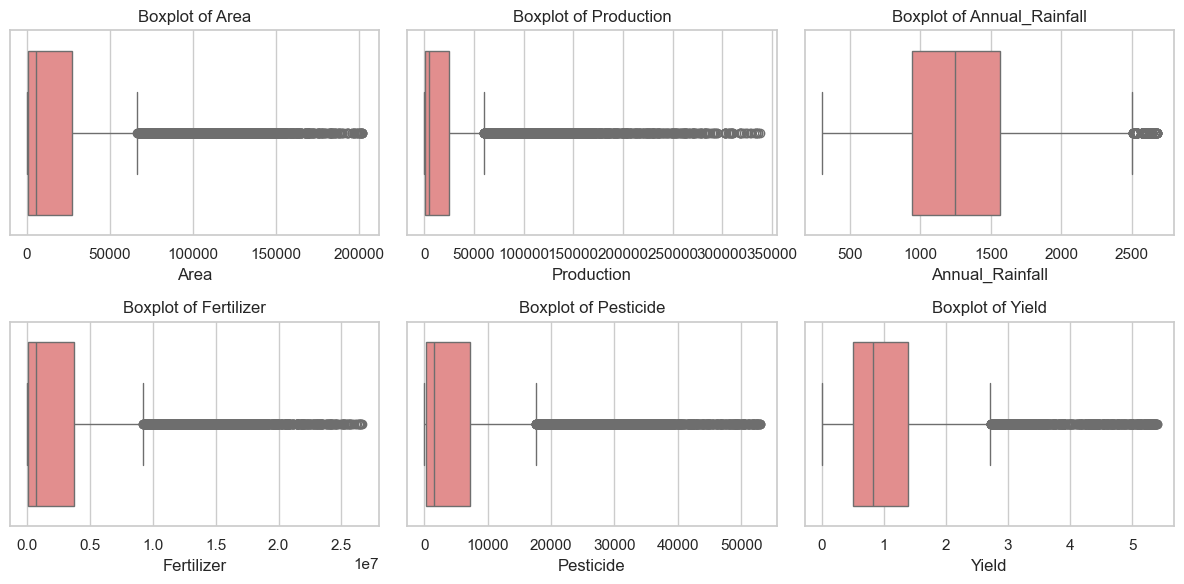

In [34]:
numerical_cols = ['Area', 'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield']

plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=cropDf, x=col, color="lightcoral")
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Crop Distribution

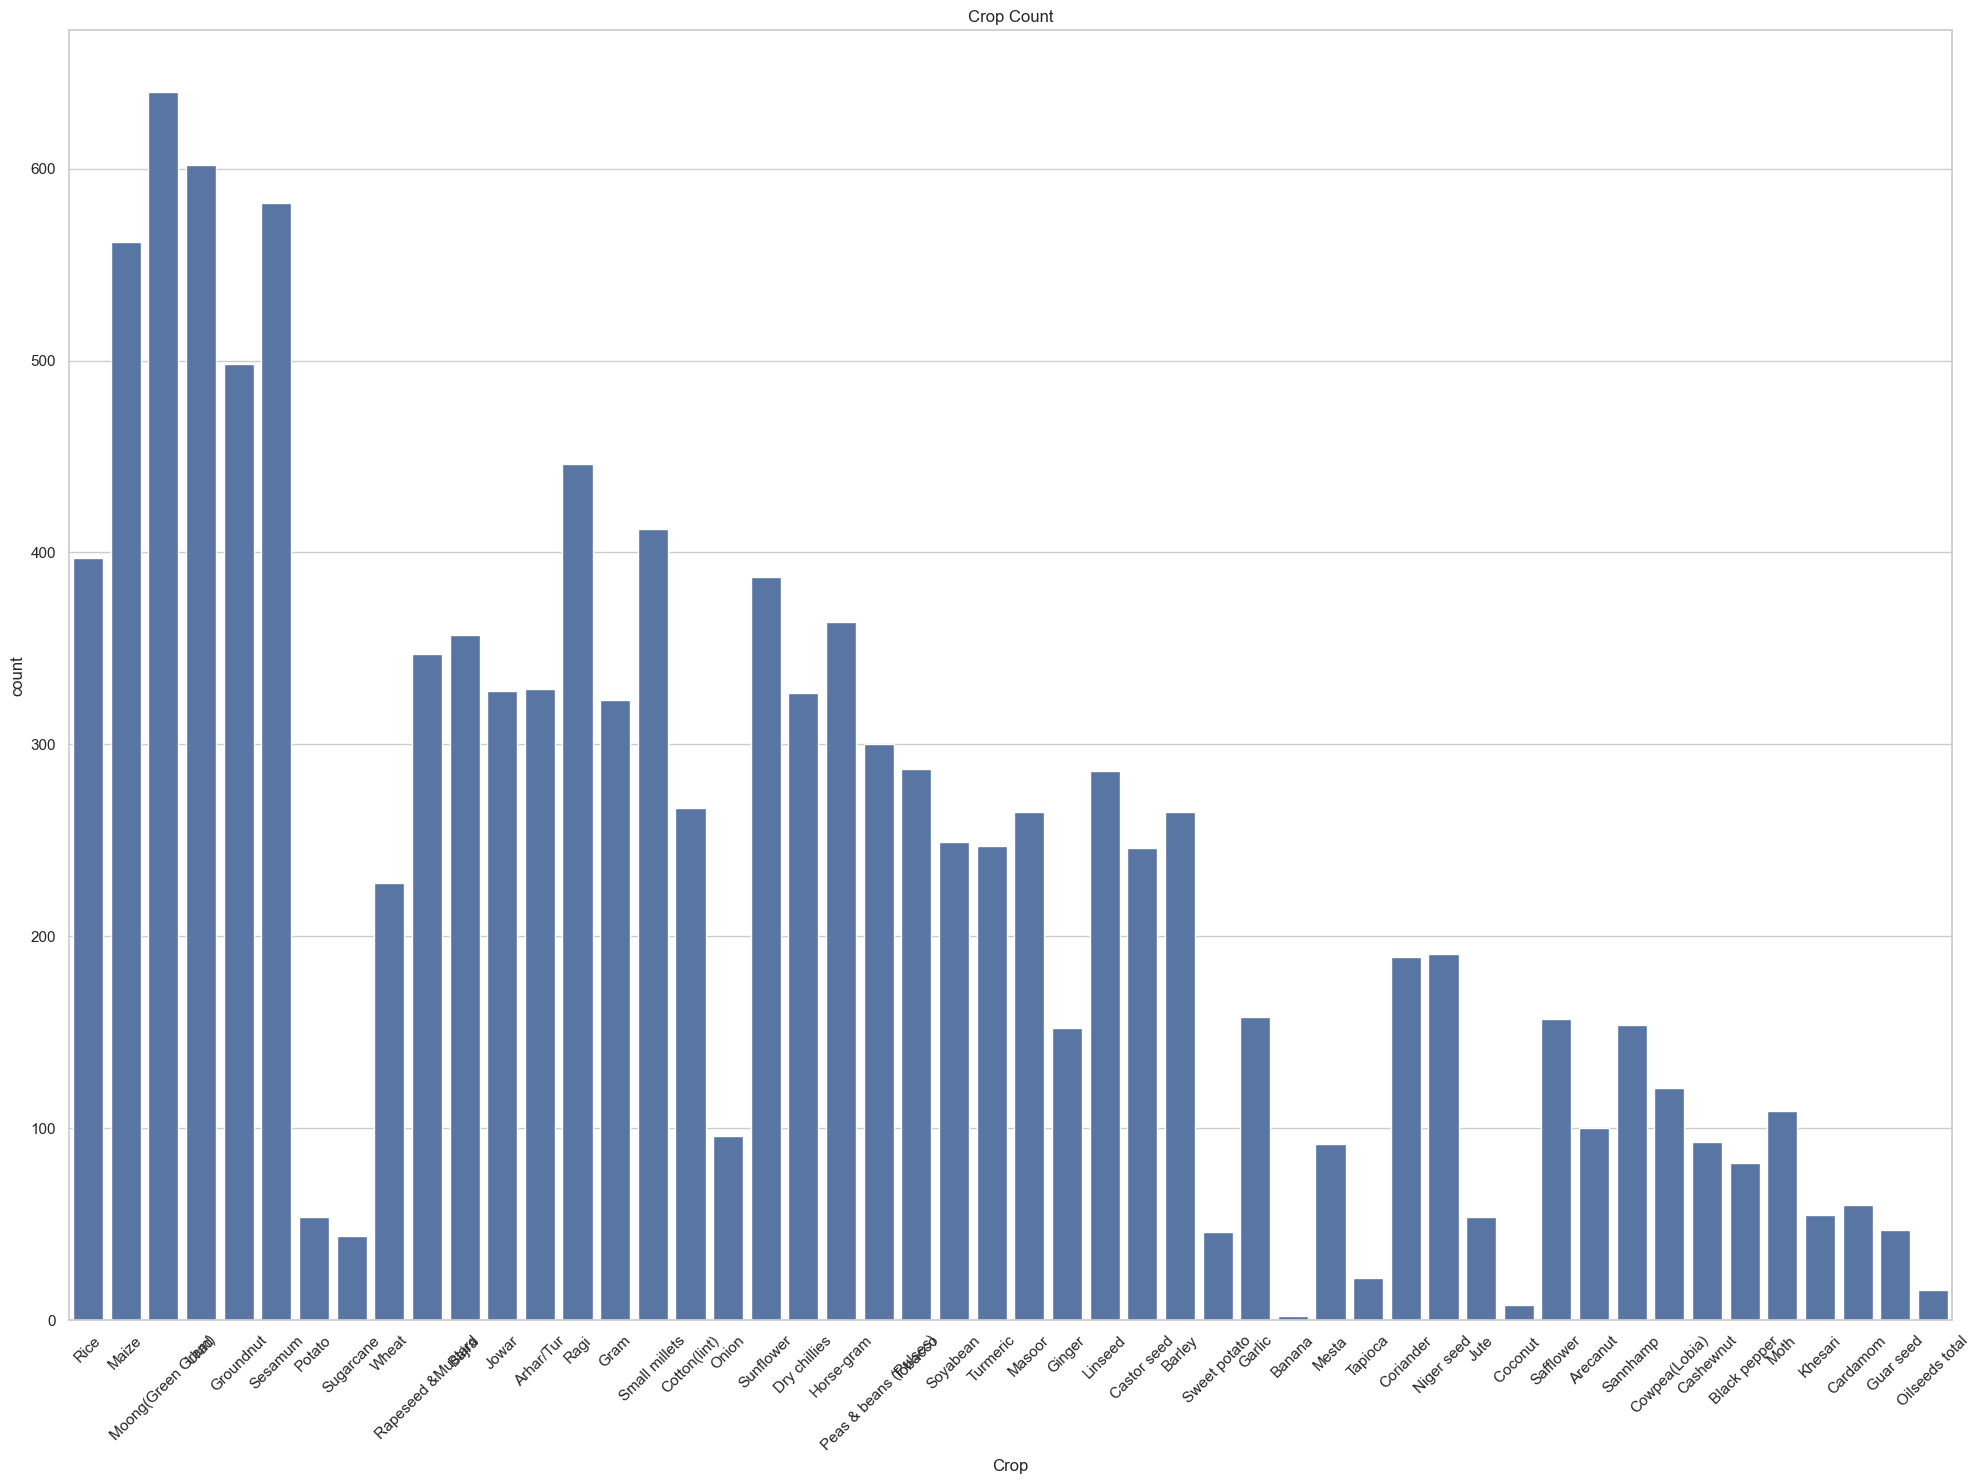

In [35]:
sns.set(style="whitegrid")

# Plot 1: Crop
plt.figure(figsize=(20, 15))
sns.countplot(data=cropDf, x='Crop', order=data['Crop'].value_counts().index)
plt.title("Crop Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Countplot: Shows the frequency of each crop in the dataset.

Third Image Observations:
Some crops (e.g., "Rice", "Wheat") appear frequently, while others are rare.
Imbalanced data may require techniques like stratification in train-test splits.

Numerical Columns' Distribution

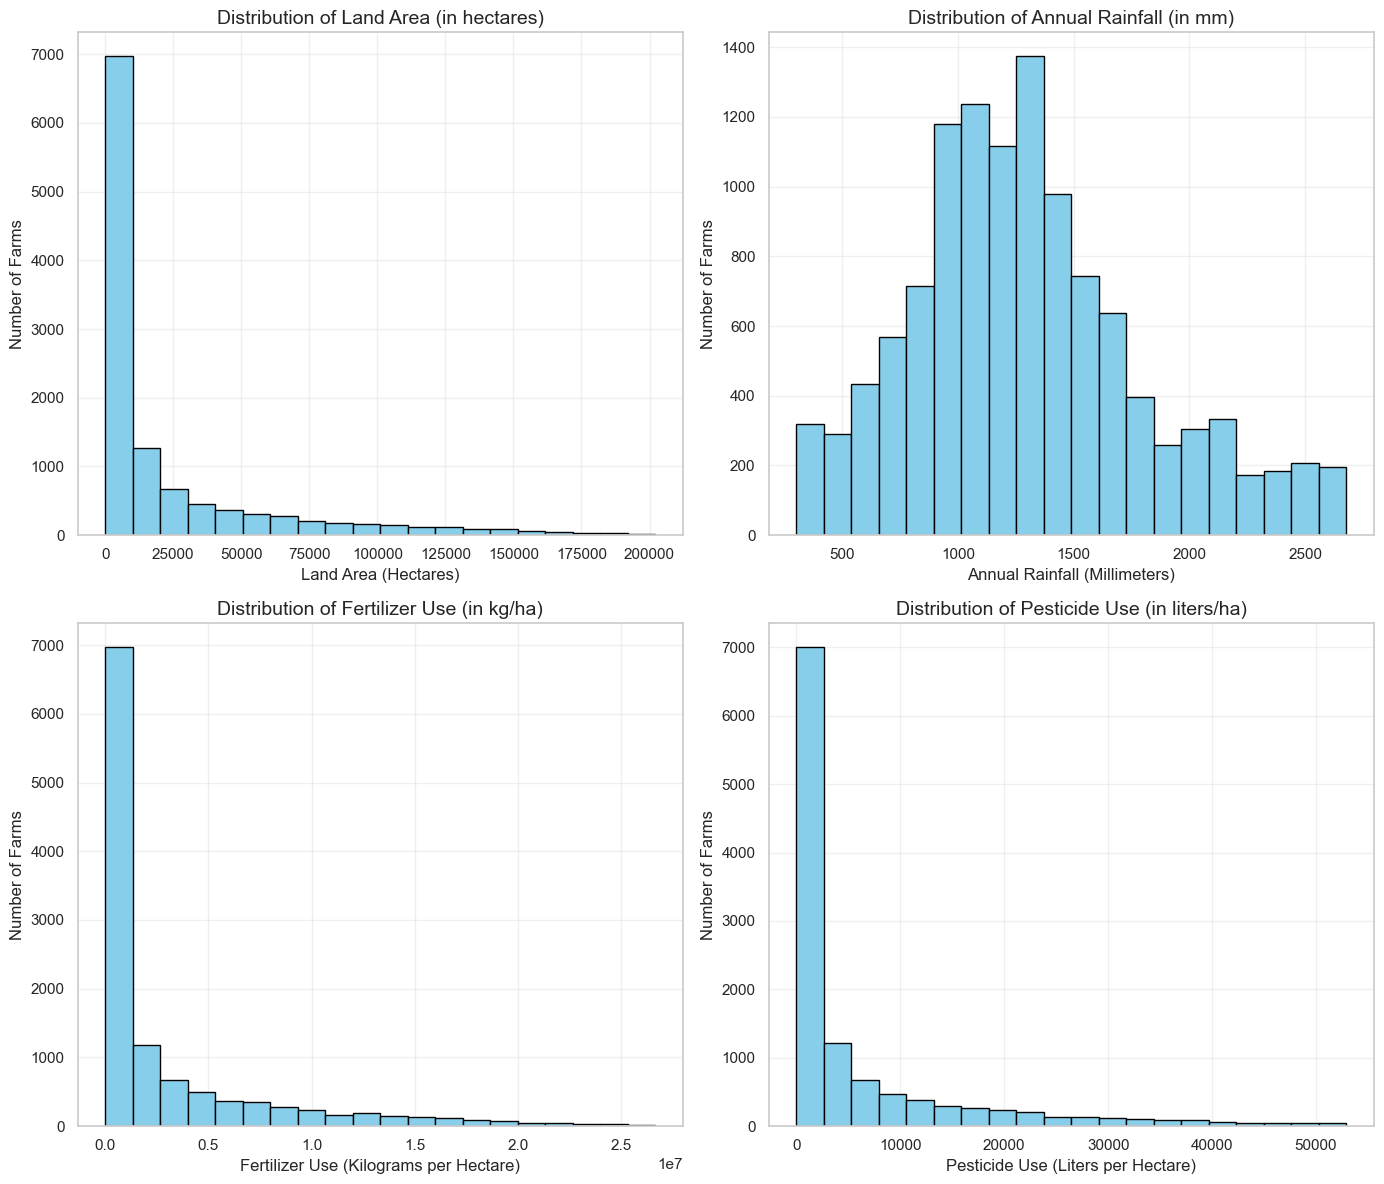

In [36]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].hist(cropDf['Area'], bins=20, edgecolor='black', color='skyblue')
axes[0, 0].set_title('Distribution of Land Area (in hectares)', fontsize=14)
axes[0, 0].set_xlabel('Land Area (Hectares)', fontsize=12)
axes[0, 0].set_ylabel('Number of Farms', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(cropDf['Annual_Rainfall'], bins=20, edgecolor='black', color='skyblue')
axes[0, 1].set_title('Distribution of Annual Rainfall (in mm)', fontsize=14)
axes[0, 1].set_xlabel('Annual Rainfall (Millimeters)', fontsize=12)
axes[0, 1].set_ylabel('Number of Farms', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(cropDf['Fertilizer'], bins=20, edgecolor='black', color='skyblue')
axes[1, 0].set_title('Distribution of Fertilizer Use (in kg/ha)', fontsize=14)
axes[1, 0].set_xlabel('Fertilizer Use (Kilograms per Hectare)', fontsize=12)
axes[1, 0].set_ylabel('Number of Farms', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(cropDf['Pesticide'], bins=20, edgecolor='black', color='skyblue')
axes[1, 1].set_title('Distribution of Pesticide Use (in liters/ha)', fontsize=14)
axes[1, 1].set_xlabel('Pesticide Use (Liters per Hectare)', fontsize=12)
axes[1, 1].set_ylabel('Number of Farms', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

plt.show()


Key Observations from Histograms:

-> Land Area (Area)
Right-skewed distribution: Most farms are small (low hectares), with few large farms.
Implication: Large farms may dominate aggregate production despite being fewer in number.

-> Annual Rainfall (Annual_Rainfall)
Bimodal distribution: Peaks around ~1000 mm and ~1500 mm.
Implication: Reflects regions with distinct wet/dry seasons (e.g., monsoon vs. arid climates).

-> Fertilizer Use (Fertilizer)
Right-skewed: Most farms use moderate amounts, with few using extremely high quantities.
Implication: Potential overuse in some farms could lead to environmental concerns.

-> Pesticide Use (Pesticide)
Right-skewed: Similar to fertilizer, with most farms using low-to-moderate amounts.
Implication: High pesticide use in outliers may indicate intensive farming practices.


Converting Seasons to Months

In [37]:
cropDf['Season'] = cropDf['Season'].str.strip()
print(cropDf['Season'].unique())

['Whole Year' 'Kharif' 'Rabi' 'Summer' 'Autumn' 'Winter']


/var/folders/x_/52cvmjtn10d55ynb59z0zn4r0000gn/T/ipykernel_2298/339001151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropDf['Season'] = cropDf['Season'].str.strip()


In [38]:
season_to_months = {
    'Whole Year': 'Whole Year',
    'Kharif': 'June-October',
    'Rabi': 'November-April',
    'Autumn': 'October-November',
    'Summer': 'March-May',
    'Winter':  'December-February',
}
cropDf['Season'] = cropDf['Season'].map(season_to_months).fillna('Unknown')
cropDf.head(10)

/var/folders/x_/52cvmjtn10d55ynb59z0zn4r0000gn/T/ipykernel_2298/1159341875.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropDf['Season'] = cropDf['Season'].map(season_to_months).fillna('Unknown')


,Crop,Season,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,Whole Year,73814.0,56708.0,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,June-October,6637.0,4685.0,2051.4,631643.29,2057.47,0.710435
2,Castor seed,June-October,796.0,22.0,2051.4,75755.32,246.76,0.238333
4,Cotton(lint),June-October,1739.0,794.0,2051.4,165500.63,539.09,0.420909
5,Dry chillies,Whole Year,13587.0,9073.0,2051.4,1293074.79,4211.97,0.643636
6,Gram,November-April,2979.0,1507.0,2051.4,283511.43,923.49,0.465455
8,Linseed,November-April,10098.0,5158.0,2051.4,961026.66,3130.38,0.461364
9,Maize,June-October,19216.0,14721.0,2051.4,1828786.72,5956.96,0.615652
10,Mesta,June-October,5915.0,29003.0,2051.4,562930.55,1833.65,4.568947
11,Niger seed,Whole Year,9914.0,5076.0,2051.4,943515.38,3073.34,0.482353


Season Standardization

Explanation:

Purpose: Standardizes seasonal names to a consistent format (e.g., "Kharif" → "June-October").

Agricultural Context:
Kharif (June-Oct): Crops like rice, maize (monsoon-dependent).
Rabi (Nov-Apr): Crops like wheat, gram (winter irrigation).
Why Important: Ensures uniformity for analysis (e.g., grouping crops by season).

Feature Scaling (Standardization)

In [39]:
scaler = StandardScaler()
scale_columns = ['Area', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']
cropDf[scale_columns] = scaler.fit_transform(cropDf[scale_columns])

cropDf.head()

/var/folders/x_/52cvmjtn10d55ynb59z0zn4r0000gn/T/ipykernel_2298/944410164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropDf[scale_columns] = scaler.fit_transform(cropDf[scale_columns])


,Crop,Season,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,Whole Year,1.342383,56708.0,1.482327,0.798072,1.640466,0.796087
1,Arhar/Tur,June-October,-0.444769,4685.0,1.482327,-0.498773,-0.408768,0.710435
2,Castor seed,June-October,-0.600160,22.0,1.482327,-0.611533,-0.586947,0.238333
4,Cotton(lint),June-October,-0.575073,794.0,1.482327,-0.593329,-0.558181,0.420909
5,Dry chillies,Whole Year,-0.259874,9073.0,1.482327,-0.364604,-0.196758,0.643636


Explanation:

-> What it Does: Transforms features to have mean=0 and std=1.
Formula: 
z =(x−μ)/σ

 
-> Why Used:
Ensures equal weight for algorithms sensitive to scale (e.g., SVM, KNN).
Avoids dominance of high-magnitude features (e.g., Area vs. Pesticide).

Correlations

In [40]:
correlation_matrix = cropDf[['Area', 'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield']].corr()
correlation_matrix

,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
Area,1.000000,0.743461,-0.153247,0.971651,0.955754,-0.047833
Production,0.743461,1.000000,-0.100382,0.750599,0.738706,0.300963
Annual_Rainfall,-0.153247,-0.100382,1.000000,-0.148762,-0.148321,0.054958
Fertilizer,0.971651,0.750599,-0.148762,1.000000,0.947063,-0.030607
Pesticide,0.955754,0.738706,-0.148321,0.947063,1.000000,-0.032053
Yield,-0.047833,0.300963,0.054958,-0.030607,-0.032053,1.000000


Key Insights:

-> Strong Positive Correlations:
Area ↔ Fertilizer (0.97), Area ↔ Pesticide (0.96): Larger farms use more inputs.
Production ↔ Area (0.74): Larger farms produce more, but not perfectly (other factors matter).

-> Weak/Negative Correlations:
Yield ↔ Area (-0.05): Smaller farms may be more yield-efficient.
Annual_Rainfall ↔ Others (~±0.15): Rainfall has minimal linear relationship with inputs.

-> Yield Drivers:
Only Production (0.30) shows moderate correlation with yield.
Takeaway: Yield is influenced by factors beyond area/inputs (e.g., crop type, soil quality).

### Model Training & Evaluation

In [47]:
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor(),
    # 'NeuralNetwork1': MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=1000, random_state=42),
    # 'NeuralNetwork2': MLPRegressor(hidden_layer_sizes=(128), max_iter=1000, random_state=42),
    # 'NeuralNetwork3': MLPRegressor(hidden_layer_sizes=(64), max_iter=1000, random_state=42),
    # 'NeuralNetwork4': MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=1000, random_state=42),
}

encoded_cropDf = pd.get_dummies(cropDf, columns=['Crop', 'Season'], drop_first=True)

X = encoded_cropDf.drop(columns=['Yield', 'Production'])
y = encoded_cropDf['Production']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Explanation:

-> Algorithms Chosen:
LinearRegression: Baseline model (assumes linear relationships).
DecisionTree: Non-linear, interpretable, prone to overfitting.
RandomForest: Ensemble of decision trees (reduces overfitting).
AdaBoost: Boosting algorithm (improves weak learners iteratively).
XGBoost: Optimized gradient boosting (handles non-linearity well).

-> Why These Models?
Cover a spectrum from simple to complex, linear to non-linear.
Evaluate which approach best captures agricultural yield patterns.

##Data Preprocessing for Models

Key Steps:

1). One-Hot Encoding (get_dummies)
Converts categorical variables (Crop, Season) into binary columns.
Example: Crop=Rice → Crop_Rice=1, Crop_Wheat=0.
Why? Models require numerical input; avoids ordinal bias.

2). Train-Test Split (test_size=0.3)
70% data for training, 30% for testing.
random_state=42 ensures reproducibility.

Model Training & Evaluation

In [48]:
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    accuracy = model.score(X_test, y_test)
    results[model_name] = {
        'MSE': mse,
        'R2_Score': r2,
        'Accuracy': accuracy
    }


Metrics Explained:

1). Mean Squared Error (MSE)
Average squared difference between actual and predicted values.
Lower is better (e.g., RandomForest has MSE = 244M vs. AdaBoost = 973M).

2). R² Score (Coefficient of Determination)
Proportion of variance in y explained by features.
Range: 0 (no fit) to 1 (perfect fit).
Example: RandomForest (R² = 0.89) explains 89% of variance.

3). Accuracy
For regression, model.score() returns R² by default.
Note: The term "accuracy" is technically incorrect here (used for classification).

Model Evaluation

Model: LinearRegression
  MSE: 698852123.9524082
  R2 Score: 0.6837074655199585
  Accuracy: 68.37%

Model: DecisionTree
  MSE: 479698066.67162895
  R2 Score: 0.7828941029260177
  Accuracy: 78.29%

Model: RandomForest
  MSE: 249328759.77532786
  R2 Score: 0.8871566349371584
  Accuracy: 88.72%

Model: AdaBoost
  MSE: 936017762.4585341
  R2 Score: 0.5763689910077334
  Accuracy: 57.64%

Model: XGBoost
  MSE: 255563699.97511125
  R2 Score: 0.8843347718125708
  Accuracy: 88.43%



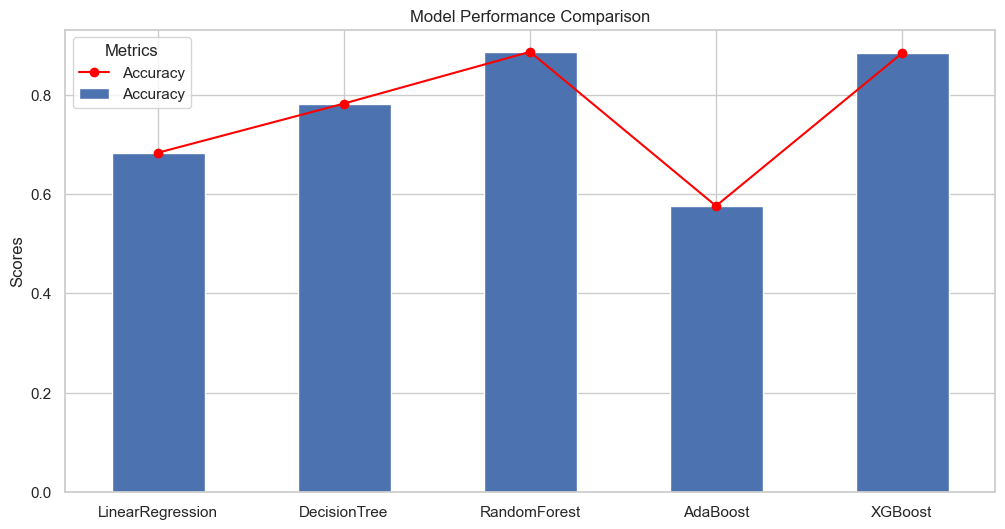

In [49]:
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"  MSE: {metrics['MSE']}")
    print(f"  R2 Score: {metrics['R2_Score']}")
    print(f"  Accuracy: {metrics['Accuracy']*100:.2f}%")
    print()

performance_df = pd.DataFrame(results).T[['Accuracy']]
performance_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Scores')
performance_df['Accuracy'].plot(kind='line', marker='o', color='red', label='Accuracy')
plt.legend(title='Metrics')
plt.show()

Visualization (Bar Plot):

RandomForest and XGBoost outperform others in R².

AdaBoost performs poorly, likely due to weak base learners or hyperparameters.

LinearRegression is decent but limited by linear assumptions.

Predicted Data Accuracy

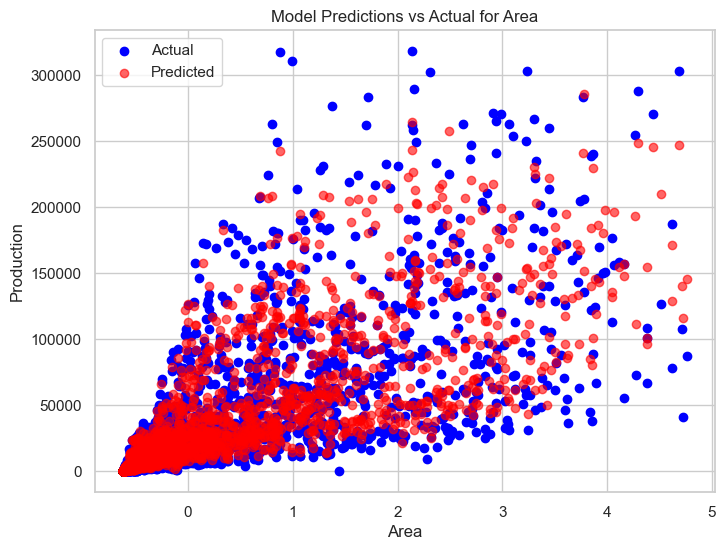

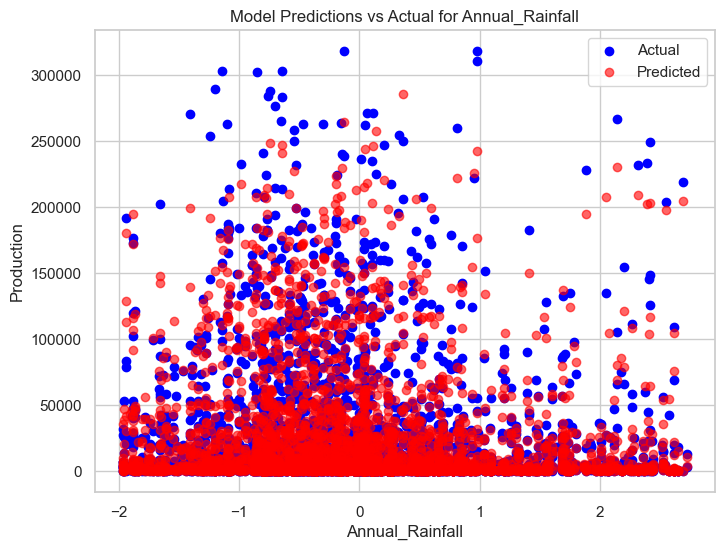

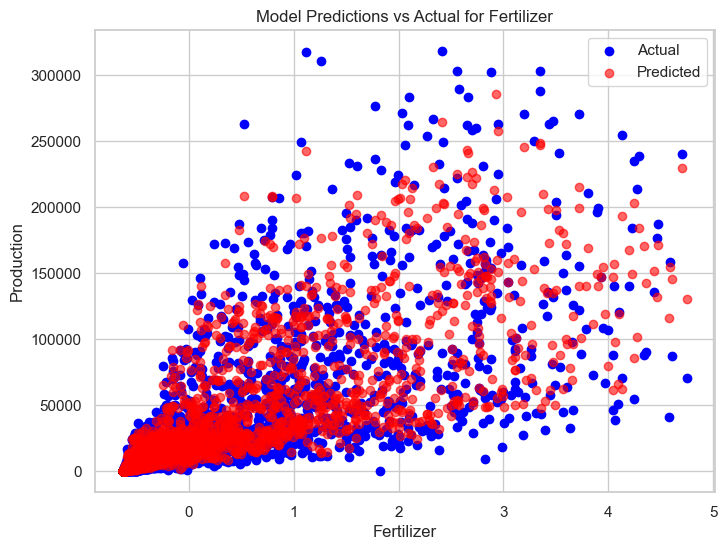

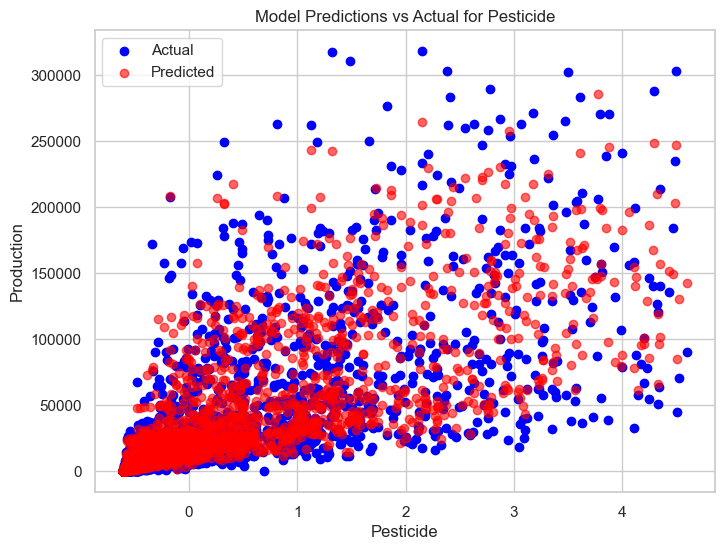

In [50]:
def plot_predictions(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test)
    for feature in feature_names:
        plt.figure(figsize=(8, 6))
        plt.scatter(X_test[feature], y_test, color='blue', label='Actual')
        plt.scatter(X_test[feature], y_pred, color='red', label='Predicted', alpha=0.6)
        plt.title(f"Model Predictions vs Actual for {feature}")
        plt.xlabel(feature)
        plt.ylabel("Production")
        plt.legend()
        plt.show()

model = models['RandomForest']
plot_predictions(model, X_test, y_test, feature_names=['Area', 'Annual_Rainfall', 'Fertilizer', 'Pesticide'])

Key Steps:

Predictions: y_pred = model.predict(X_test) generates predictions for the test set.

Visualization: For each feature:
Blue dots: Actual Production values (y_test).

Red dots: Predicted Production values (y_pred), with transparency (alpha=0.6) to show overlap.

X-axis: Feature values (e.g., Area in hectares).

Y-axis: Production values (e.g., crop output in tons).

Interpretation of Plots

For each feature, the scatter plots reveal:

-> Area vs. Production
Expected Trend: Larger farms (Area) should generally have higher Production.
Ideal Plot: Red (predicted) dots closely follow blue (actual) dots in a linear or monotonic pattern.
Issues: If red dots deviate significantly, the model may under/over-predict for certain farm sizes.

-> Annual_Rainfall vs. Production
Expected Trend: Moderate rainfall may correlate with optimal production (too little or too much can harm yields).
Ideal Plot: Clustering of red/blue dots around a "sweet spot" rainfall value.

-> Fertilizer/Pesticide vs. Production
Expected Trend: Increasing inputs may boost production up to a point (diminishing returns).
Ideal Plot: Red dots align with blue dots initially, then plateau if overuse occurs.

In [51]:
import joblib
joblib.dump(model, 'CropyModel.pkl')

['CropyModel.pkl']